In [54]:
import os
import numpy as np
import glob
import PIL.Image as Image

#pip install torchsummary
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torchvision import models
from torchsummary import summary
import torch.optim as optim
from time import time

from config.config_baseline import *
from models import Baseline
from data_loader import DRIVE
import matplotlib.pyplot as plt
from IPython.display import clear_output

ModuleNotFoundError: No module named 'pandas'

In [55]:
!pip install pandas

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 65.6 MB/s eta 0:00:0000:010:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 502.3/502.3 kB 28.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 341.8/341.8 kB 21.9 MB/s eta 0:00:00

[notice] A new release of pip is available: 23.0.1 -> 23.1.2
[notice] To update, run: pip install --upgrade pip


In [27]:
train_transform = transforms.Compose([transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)), 
                                    transforms.ToTensor()])
test_transform = transforms.Compose([transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)), 
                                    transforms.ToTensor()])

trainset = DRIVE(train=True, transform=train_transform, data_path = path)
train_loader = DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True, num_workers=3)
testset = DRIVE(train=False, transform=test_transform, data_path = path)
test_loader = DataLoader(testset, batch_size=BATCH_SIZE, shuffle=False, num_workers=3)

print('Loaded %d training images' % len(trainset))
print('Loaded %d test images' % len(testset))

Loaded 20 training images
Loaded 20 test images


In [28]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"device: {device}")
model = Baseline()
model.to(device)

device: cuda


Baseline(
  (enc_conv0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (enc_conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (enc_conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (enc_conv3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (bottleneck_conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (upsample0): Upsample(size=16, mode='nearest')
  (dec_conv0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (upsample1): Upsample(size=32, mode='nearest')
  (dec_conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=

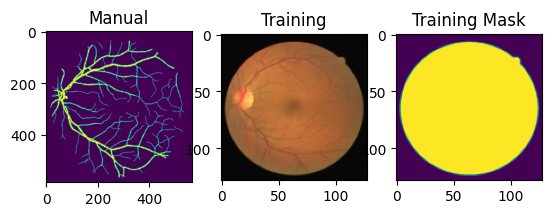

In [53]:
im_manual = Image.open(manual_path + '/21_manual1.gif')
im_train, mask_train = testset[0]
im_train = im_train.permute(1, 2, 0)
mask_train = mask_train.permute(1, 2, 0)
fig, axs = plt.subplots(1,3)
axs[0].imshow(im_manual)
axs[0].set_title("Manual")
axs[1].imshow(im_train)
axs[1].set_title("Training")
axs[2].imshow(mask_train)
axs[2].set_title("Training Mask")
plt.show()